In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report
from tqdm import tqdm

from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Training/no_tumor/image(84).jpg
/kaggle/input/Training/no_tumor/image(44).jpg
/kaggle/input/Training/no_tumor/image(245).jpg
/kaggle/input/Training/no_tumor/6.jpg
/kaggle/input/Training/no_tumor/image(238).jpg
/kaggle/input/Training/no_tumor/image(196).jpg
/kaggle/input/Training/no_tumor/image(108).jpg
/kaggle/input/Training/no_tumor/image(310).jpg
/kaggle/input/Training/no_tumor/image (5).jpg
/kaggle/input/Training/no_tumor/image(186).jpg
/kaggle/input/Training/no_tumor/image(29).jpg
/kaggle/input/Training/no_tumor/image(140).jpg
/kaggle/input/Training/no_tumor/image(224).jpg
/kaggle/input/Training/no_tumor/image (61).jpg
/kaggle/input/Training/no_tumor/image(173).jpg
/kaggle/input/Training/no_tumor/image(52).jpg
/kaggle/input/Training/no_tumor/image (52).jpg
/kaggle/input/Training/no_tumor/image(174).jpg
/kaggle/input/Training/no_tumor/image(203).jpg
/kaggle/input/Training/no_tumor/image(33).jpg
/kaggle/input/Training/no_tumor/image(283).jpg
/kaggle/input/Training/no_tu

In [3]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('../input/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 97.04it/s]


In [4]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

def attention_layer(inputs):
    attention = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    attention = tf.keras.layers.Dense(units=inputs.shape[-1], activation='sigmoid')(attention) 
    attention = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(attention)
    attention = tf.keras.layers.Multiply()([inputs, attention])
    return attention

model = resnet.output
model = attention_layer(model)  # Add attention mechanism
model = tf.keras.layers.GlobalAveragePooling2D()(model)  # Global average pooling to reduce dimensions
model = tf.keras.layers.Dropout(rate=0.5)(model)  # Dropout to reduce overfitting
model = tf.keras.layers.Dense(4, activation='softmax')(model)  # Final classification layer for 4 classes

model = tf.keras.models.Model(inputs=resnet.input, outputs=model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
#model.summary()

In [9]:
tensorboard = TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [10]:
model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


I0000 00:00:1727990230.279752     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6176 - loss: 1.1796
Epoch 1: val_accuracy improved from -inf to 0.15306, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 113s 568ms/step - accuracy: 0.6187 - loss: 1.1757 - val_accuracy: 0.1531 - val_loss: 67.2490 - learning_rate: 0.0010
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8578 - loss: 0.3960
Epoch 2: val_accuracy improved from 0.15306 to 0.16327, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8579 - loss: 0.3956 - val_accuracy: 0.1633 - val_loss: 8.8346 - learning_rate: 0.0010
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9207 - loss: 0.2270
Epoch 3: val_accuracy improved from 0.16327 to 0.17347, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9207 - loss: 0.2270 - val_accuracy: 0.1735 - val_loss: 15.9251 - learning_rate: 0.0010
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

In [11]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step


In [12]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        93
           1       0.94      0.92      0.93        51
           2       0.95      0.97      0.96        96
           3       0.95      1.00      0.97        87

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



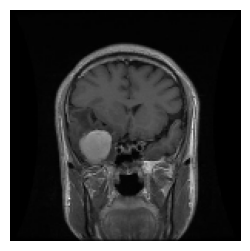

In [18]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()